In [2]:
import matplotlib.pyplot as plt
import numpy as np
import load_data
import Zuschneiden
import Features
import get_classes
import cluster_representatives
import pickle

# load Data
with open('data/class_features.pkl', 'rb') as class_features_file:
    class_features = pickle.load(class_features_file)
    
with open('data/class_std.pkl', 'rb') as class_std_file_file:
    class_std = pickle.load(class_std_file_file)

with open('data/class_index_models.pkl', 'rb') as class_index_models_file:
    class_index_models = pickle.load(class_index_models_file)

with open('data/index_matrix.pkl', 'rb') as index_matrix_file:
    index_matrix = pickle.load(index_matrix_file)

In [6]:
# load initial data and calculate sequences
matrix,static_features,kopfzeile=load_data.load_matrix(r"..\CSV_SDMflex\SDMflex_V2_Anwendung_final.csv")   # load learning Data
Schnitt = Zuschneiden.Sectioning(matrix,kopfzeile,G=1, c=True)   # calculate sequences
Zuschnitte = Features.region_feature(matrix,Schnitt,kopfzeile,static_features)   # calculate features

In [7]:
# get feature vector for segmentation
features=[]
for i in range(len(Zuschnitte)):
    # Used features are distance (x,y,z), average spindle speed and duration (spindlespeed is diveded by 6 due to recording)
    features += [(Zuschnitte[i][1][0], Zuschnitte[i][1][1],Zuschnitte[i][1][2], Zuschnitte[i][1][4]/6, Zuschnitte[i][1][5])]
features = np.array(features)

# inline segmentation
inline_lables = get_classes.inline_class(features, class_features, class_std)

In [8]:
# Calculation of the values for each Sequence and addit to the index_matrix
class_rep, class_len_rep, class_nrs_inline = cluster_representatives.get_cluster_ts_inline(Zuschnitte, inline_lables)  # get the sorted representative cluster timeseries (cluster --> source --> all ts)

print(len(index_matrix))
index = np.linspace(kopfzeile.index('Speed_SP')+1, len(kopfzeile)-1, len(kopfzeile) - kopfzeile.index('Speed_SP') - 1).astype(int)   # get relevant indices

# Update the index-matrix based on the current metric
for i in range(len(class_nrs_inline)):
    class_nr = class_nrs_inline[i]

    for sig_index in index:
        for nr_ts in range(len(class_rep[i][sig_index])):

            index_matrix[class_nr][sig_index - kopfzeile.index('Speed_SP') - 1] += [class_index_models[class_nr][sig_index  - kopfzeile.index('Speed_SP') - 1].get_index(class_rep[i][sig_index][nr_ts], 'dist_to_mean')]

2


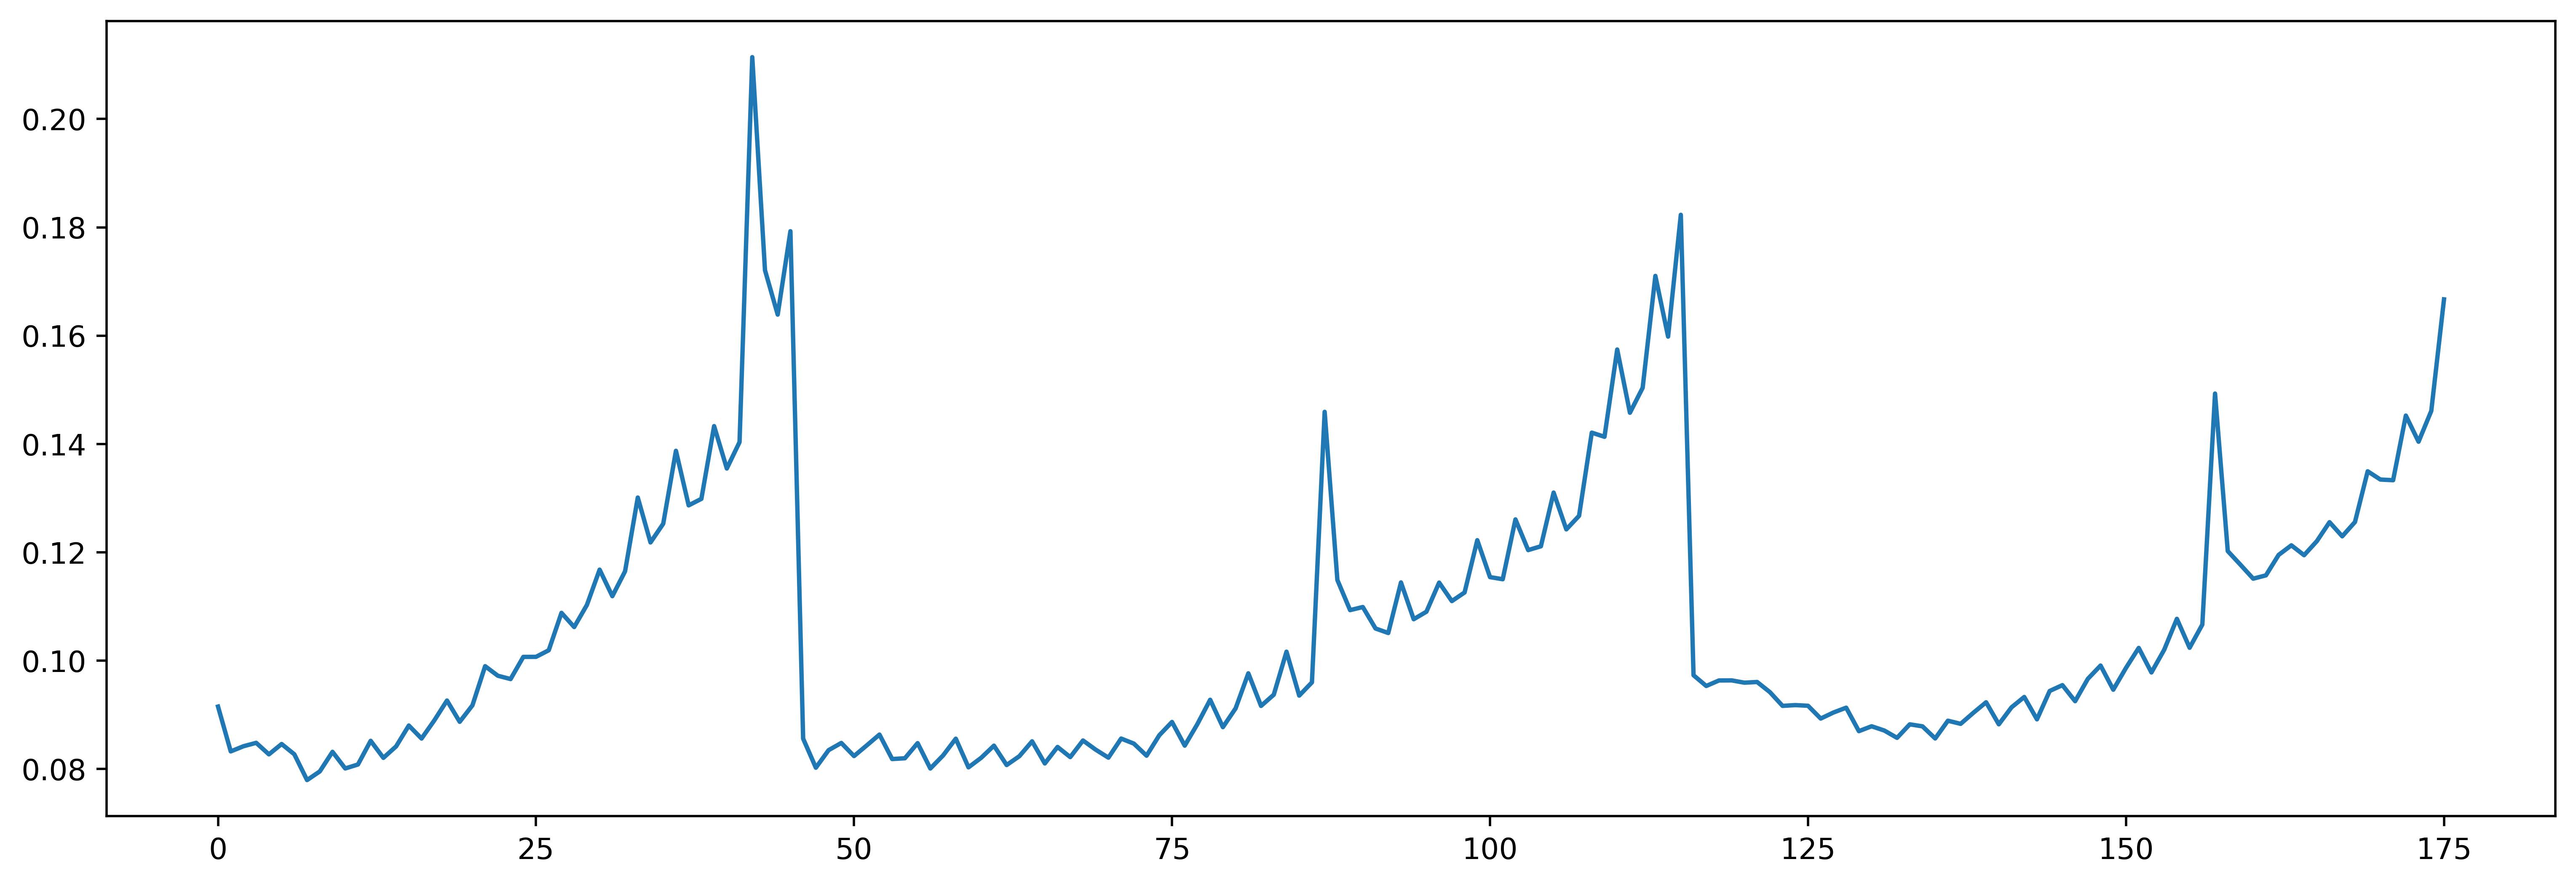

In [9]:
# Plot an index series
fig, ax = plt.subplots( figsize=(15, 5), dpi=500)
c=0
s=1
ax.plot(index_matrix[c][s] )

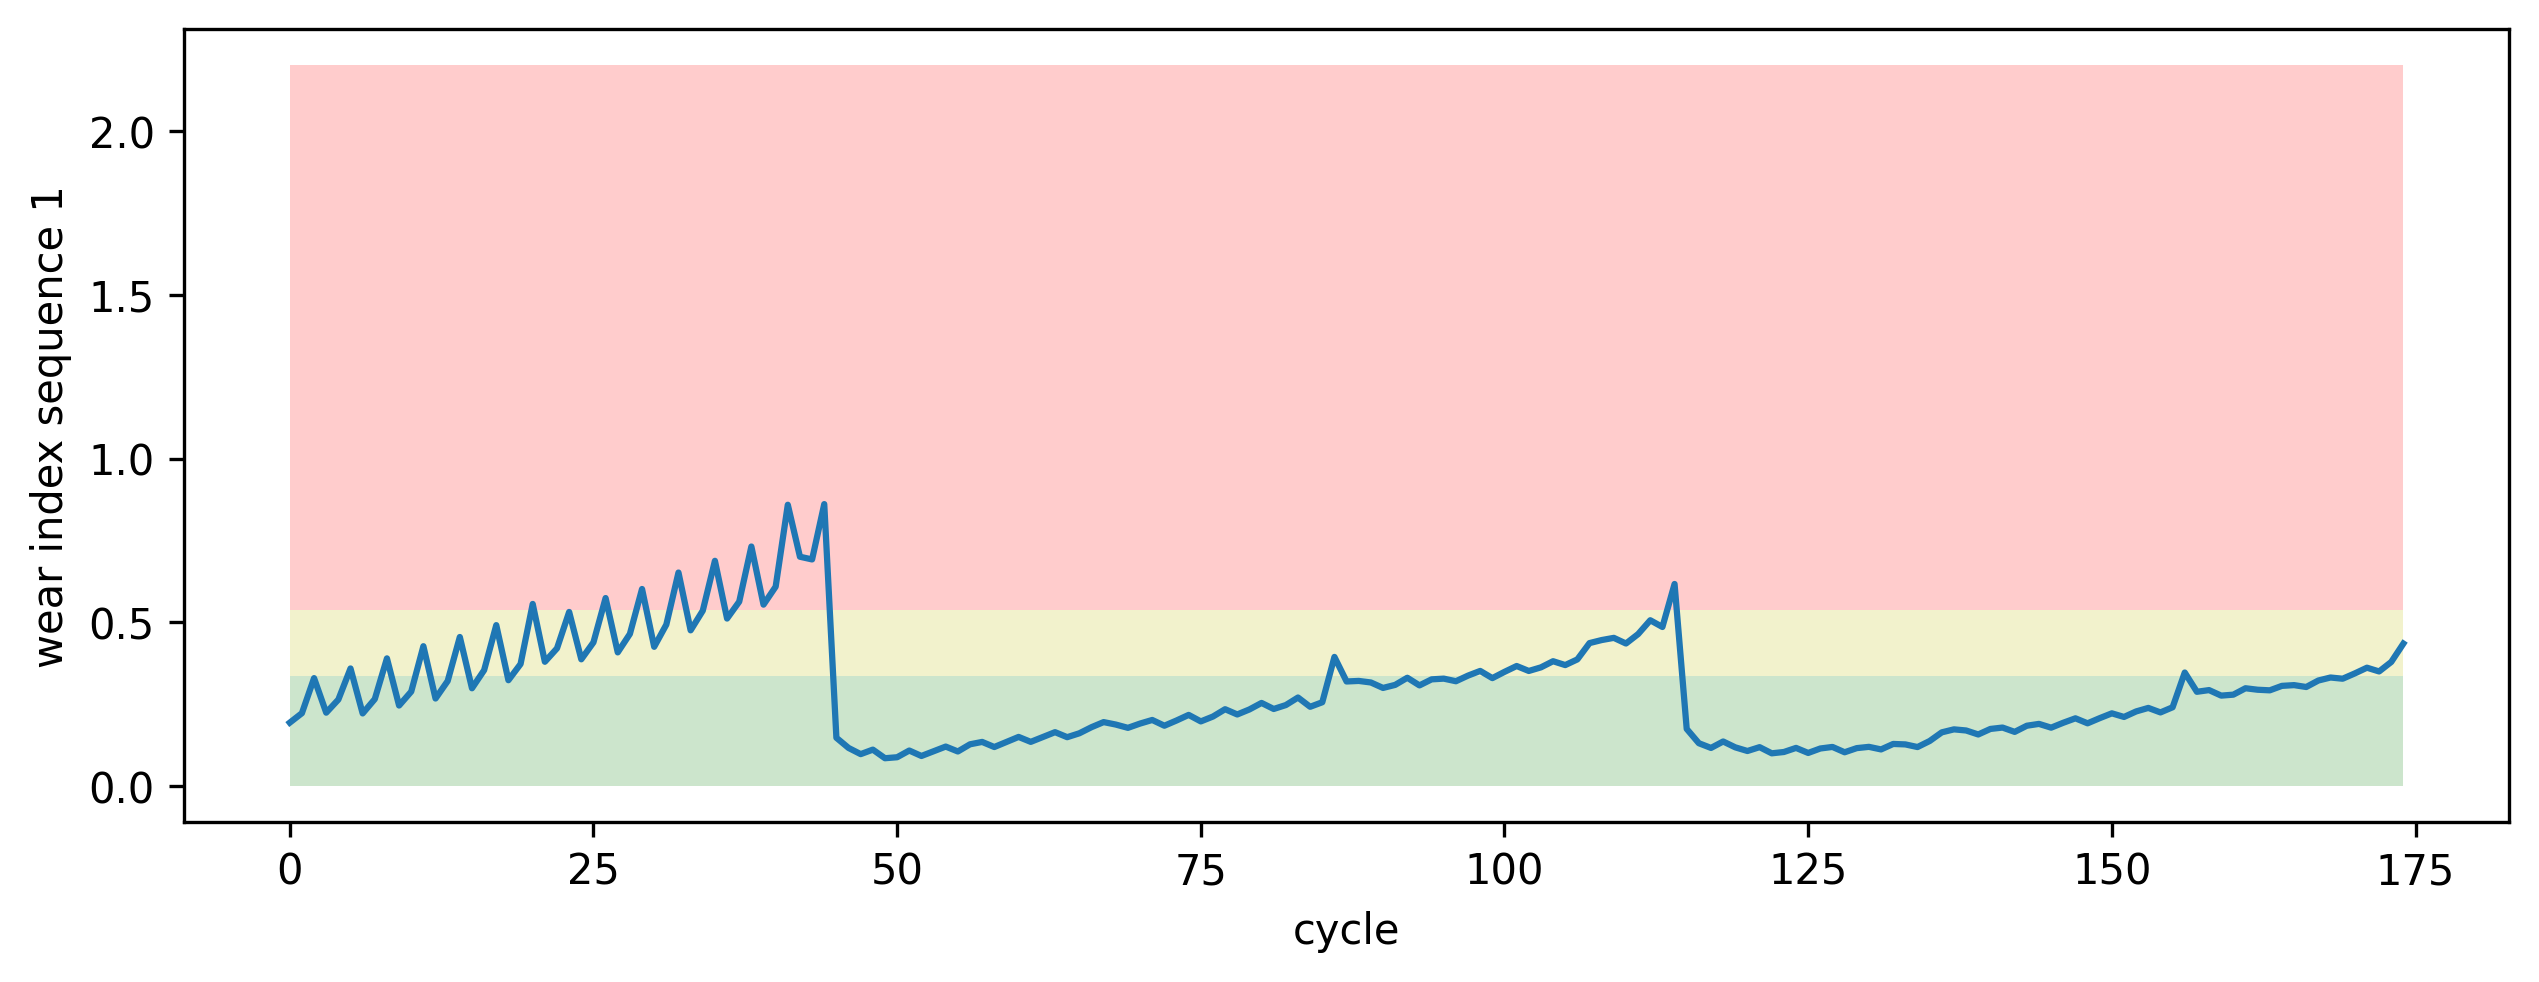

In [13]:
# plots for presentations

import scipy
import imageio.v2 as imageio
images = []
c=0
# fig, ax = plt.subplots(4, figsize=(15, 5), dpi=500)
# ax[0].plot(index_matrix[c][0])
# ax[1].plot(index_matrix[c][1])
# ax[2].plot(index_matrix[c][2])
# ax[3].plot(index_matrix[c][3])
# plt.savefig(f'C:\\Users\\stroebel\\Desktop\pic.png')

upper=0
pos_lower = 0

pp = [1,1,1,1]
factor=0.1
cut = []
cut_pos=[]
p= []



for i in range(1,len(index_matrix[c][0])):


    data3 = index_matrix[c][3][i]-index_matrix[c][3][i-1]
    
    if data3 < -0.3:
        cut += [index_matrix[c][3][i]]
        cut_pos += [i]

        if pp[0] == 1:
            f=1
        else:
            f=factor

        pp[0]= pp[0]*(1-f) + scipy.stats.spearmanr( index_matrix[c][0][pos_lower:i-1] , range(i-1-pos_lower))[0]**3*f
        pp[1]= pp[1]*(1-f) + scipy.stats.spearmanr( index_matrix[c][1][pos_lower:i-1] , range(i-1-pos_lower))[0]**3*f
        pp[2]= pp[2]*(1-f) + scipy.stats.spearmanr( index_matrix[c][2][pos_lower:i-1] , range(i-1-pos_lower))[0]**3*f
        pp[3]= pp[3]*(1-f) + scipy.stats.spearmanr( index_matrix[c][3][pos_lower:i-1] , range(i-1-pos_lower))[0]**3*f
        
        p += [pp[0]*index_matrix[0][0][i] +pp[1]*index_matrix[0][1][i] +pp[2]*index_matrix[0][2][i] +pp[3]*index_matrix[0][3][i] ] 

        upper= upper*(1-f) + p[-3]*f


    else:
        p += [pp[0]*index_matrix[0][0][i] +pp[1]*index_matrix[0][1][i] +pp[2]*index_matrix[0][2][i] +pp[3]*index_matrix[0][3][i] ] 


fig, ax = plt.subplots( figsize=(10,3.5), dpi=300)
null=[0]*len(p)
x=range(len(p))
    

green = [upper/2]*len(p)
yel = [upper*0.8]*len(p)
    
red= [2.2]*len(p)
ax.fill_between(x, red, yel, facecolor='red', interpolate=True, alpha=.2)
ax.fill_between(x, yel,green, facecolor='y', interpolate=True, alpha=.2)
ax.fill_between(x, green, facecolor='green', interpolate=True, alpha=.2)

ax.plot(x,p)

ax.set_ylabel('wear index sequence 1')
ax.set_xlabel('cycle')
plt.savefig(f'..\Plots\pic{i}.png')
        
# images.append(imageio.imread(f'C:\\Users\\stroebel\\Desktop\\Test\\pic{i}.png'))

# imageio.mimsave(r'C:\Users\stroebel\Desktop/movie_2.gif', images)

2


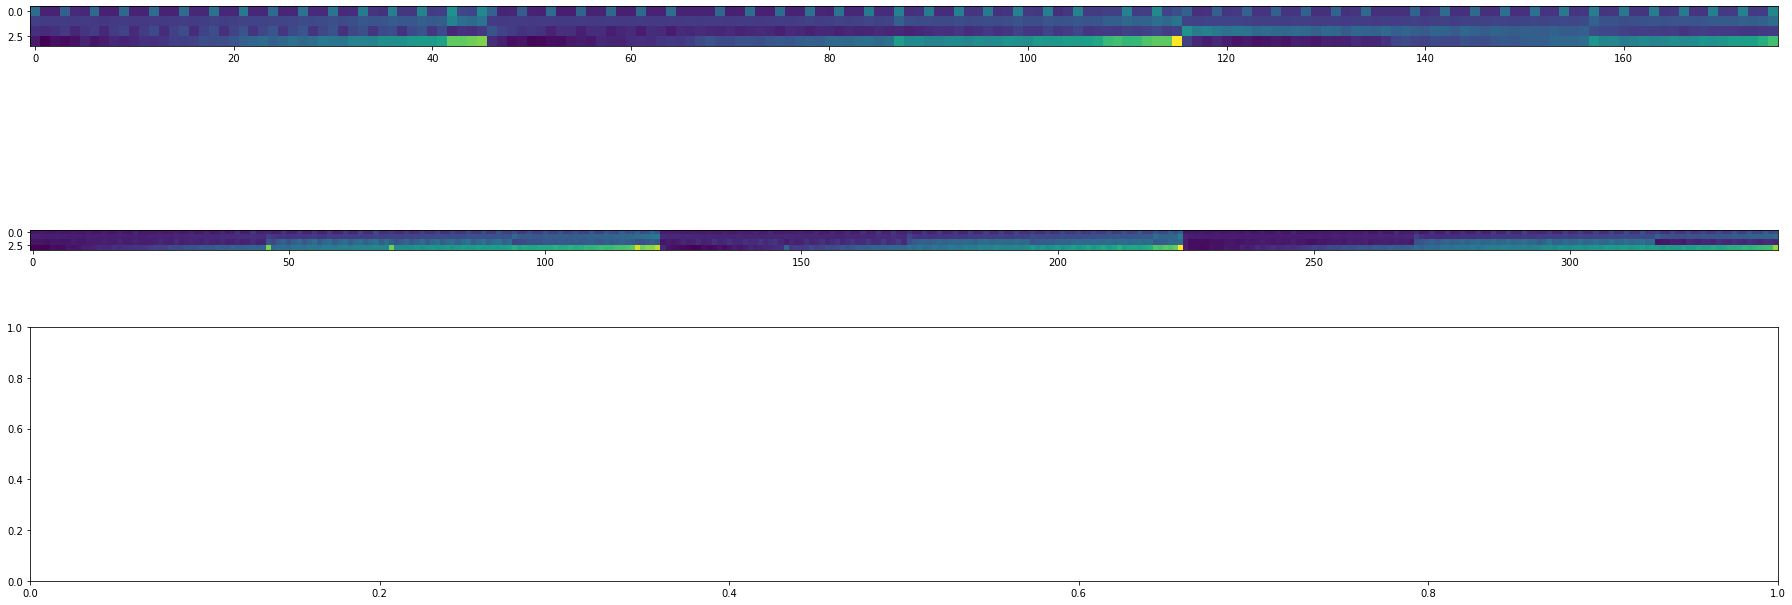

In [16]:
# Heatmaps of the anomalie index
fig, ax = plt.subplots(3,figsize=(25, 10))
print(len(index_matrix))
im = ax[0].imshow(index_matrix[0])
im = ax[1].imshow(index_matrix[1])
im = ax[2].imshow(index_matrix[2])
fig.tight_layout()
plt.show()